# Neighborhood

<!-- SUMMARY: Definition of the Neighborhood concept. This tutorial gives hints on the parameters of the Moving Neighborhood -->

<!-- CATEGORY: Basic_Objects -->

This file is meant to demonstrate the use of gstlearn for Moving Neighborhood search

In [1]:
import numpy as np
import pandas as pd
import sys
import os
import gstlearn as gl
import gstlearn.plot as gp
import gstlearn.document as gdoc
import matplotlib.pyplot as plt
import random as rnd

gdoc.setNoScroll()

<IPython.core.display.Javascript object>

Setting some global variables

In [2]:
# Set the Global Options
verbose = True
flagGraphic = True

# Define the Space Dimension
ndim = 2
gl.defineDefaultSpace(gl.ESpaceType.RN, ndim)

# Set the Seed for the Random Number generator
gl.law_set_random_seed(5584)
rnd.seed(13155)

In this paragraph, we generate a Poisson data set and check various neighborhoods around one specific node of a regular grid.

In [3]:
dxref = 0.1
grid = gl.DbGrid.create(nx=[10,10],dx=[dxref,dxref])
xlim = grid.getExtrema(0)
ylim = grid.getExtrema(1)

## Random Point data set

In [4]:
coormin = grid.getCoorMinimum()
coormax = grid.getCoorMaximum()
nech = 100
data = gl.Db.createFromBox(nech, coormin, coormax)

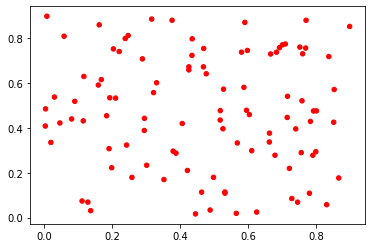

In [5]:
cmap = gp.getColorMap(100)
res = gp.plot(data)

### Checking standard neighborhood

Defining a standard Moving Neighborhood

In [6]:
nmini = 1
nmaxi = 15
radius = 0.3
nsect = 8
nsmax = 3
neigh = gl.NeighMoving.create(False, nmaxi, radius, nmini, nsect, nsmax)
neigh


Moving Neighborhood
Minimum number of samples           = 1
Maximum number of samples           = 15
Number of angular sectors           = 8
Maximum number of points per sector = 3
Maximum horizontal distance         = 0.3

Checking the neighborhood around a central grid node

In [7]:
node = 55
neigh.attach(data, grid)
ranks = gl.VectorInt()
neigh.select(node, ranks)

dataSel = data.clone()
dum = dataSel.addSelectionByRanks(ranks)

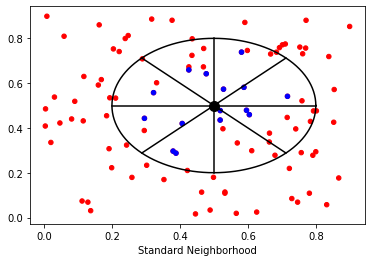

In [8]:
gp.plot(data)
gp.plot(dataSel, c='blue')
gp.neigh(neigh, grid, node, flagCell=False)
gp.decoration("Standard Neighborhood")

### Defining variable block extensions

In this section, we will generate variables in the Grid which contain the cell extension: this cell extension replaces the constant value of the mesh.

In [9]:
nech = grid.getNSample()
mini = 0.5
maxi = 2.5
blx = []
bly = []
for i in range(nech):
    blx.append(dxref * rnd.uniform(mini, maxi))
    bly.append(dxref * rnd.uniform(mini, maxi))

dum = grid.addColumns(blx, "X-ext", gl.ELoc.BLEX, 0)
dum = grid.addColumns(bly, "Y-ext", gl.ELoc.BLEX, 1)

The following display shows each block with its center and its cell extension.

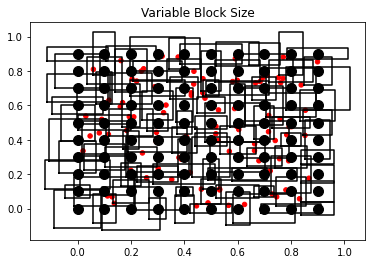

In [10]:
gp.plot(data)
gp.decoration(title="Variable Block Size")

for node in range(nech):
    gp.sample(grid.getSampleCoordinates(node))
    gp.curve(grid.getCellEdges(node))

We choose a specific cell again and determine the standard **block** neighborhood

In [11]:
node = 56
neigh.attach(data, grid)
ranks = gl.VectorInt()
neigh.select(node, ranks)

dataSel = data.clone()
dum = dataSel.addSelectionByRanks(ranks)

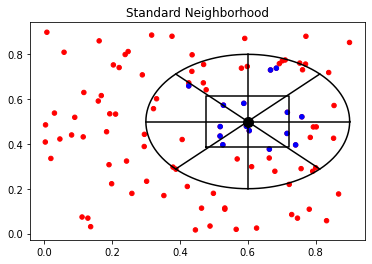

In [12]:
gp.plot(data)
gp.plot(dataSel, c='blue')
gp.neigh(neigh, grid, node, flagCell=True)
gp.decoration(title="Standard Neighborhood")

Use the Cell neighborhood to force the selection of all samples belonging to the block

In [13]:
nmini = 1
neigh = gl.NeighCell.create(False, nmini)
neigh


Cell Neighborhood
Reject samples which do not belong to target Block

In [14]:
node = 56
neigh.attach(data, grid)
ranks = gl.VectorInt()
neigh.select(node, ranks)

dataSel = data.clone()
dum = dataSel.addSelectionByRanks(ranks)

Argument 'object' ( NeighCell ) must be a valid type among ['NeighMoving']


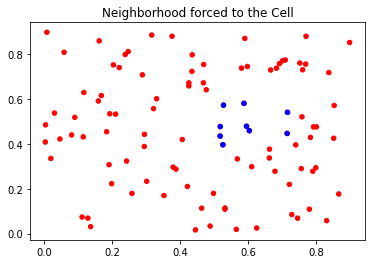

In [15]:
gp.plot(data)
gp.plot(dataSel, c='blue')
gp.neigh(neigh, grid, node, flagCell=True)
gp.decoration(title="Neighborhood forced to the Cell")

## Data gathered along lines

This chapter is meant to illustrate the specific problem when data are located along lines. 

We assume that the distance between lines is much larger that the distance within each line. For illustrating this case, we generate the data as the nodes of a regular 2D grid with a grid mesh which is very different along X (across line) and Y (along line). The file is ultimately converted into a Point file to make the rest of the procedure more flexible.µ

In [ ]:
grid = gl.DbGrid.create(nx=[20,100], dx=[10,1])
iuid = grid.addColumns(gl.VectorHelper.simulateUniform(grid.getNSample()), "z", gl.ELoc.Z)
point = gl.Db.createReduce(grid)

In [ ]:
res = gp.plot(point, s=2)

Check the neighborhood search for a target located close to one line, say at coordinates [98, 50]

In [ ]:
target = gl.Db.createFromOnePoint([98, 50])

Create a standard neighborhood, say with 10 samples per neighborhood and a radius of 7.

In [ ]:
nmini = 1
nmaxi = 10
radius = 7
neigh = gl.NeighMoving.create(False, nmaxi, radius, nmini)
neigh

In [ ]:
neigh.attach(point, target)
ranks = gl.VectorInt()
neigh.select(0, ranks)

pointSel = point.clone()
dum = pointSel.addSelectionByRanks(ranks)

In [ ]:
gp.plot(point, s=2)
gp.plot(pointSel, c='blue')
gp.neigh(neigh, target, 0)
gp.decoration("Standard Neighborhood - Small Radius")

With no surprise, all samples are gathered on the closest line. This may be a problem when performing the Estimation (using Kriging) of a variable which is characterized by a First Order Random Function: as a matter of fact, the Linear System is singular if all samples are located on a single line (whatever its orientation).
Note that in the case of a Second Order Random Function, we must avoid having samples located on a second order Variety, e.g. a circle, an ellipse or 2 lines).

The first idea is to use the angular sectors: here we consider a new neighborhood adding this constraints when selecting the samples.

In [ ]:
nmini = 1
nmaxi = 10
radius = 7
nsect = 8
nsmax = 3
neigh = gl.NeighMoving.create(False, nmaxi, radius, nmini, nsect, nsmax)
neigh

In [ ]:
neigh.attach(point, target)
ranks = gl.VectorInt()
neigh.select(0, ranks)
pointSel = point.clone()
dum = pointSel.addSelectionByRanks(ranks)

In [ ]:
gp.plot(point, s=2)
gp.plot(pointSel, c='blue')
gp.neigh(neigh, target, 0)
gp.decoration("Small Radius - Few Sectors")

Despite the use of angular sectors, the samples selected in the neighborhood still belong to a single line. The obvious reason is the size of the neighborhood radius which must be enlarged.

In [ ]:
nmini = 1
nmaxi = 10
radius = 20
nsect = 8
nsmax = 3
neigh = gl.NeighMoving.create(False, nmaxi, radius, nmini, nsect, nsmax)
neigh

In [ ]:
neigh.attach(point, target)
ranks = gl.VectorInt()
neigh.select(0, ranks)
pointSel = point.clone()
dum = pointSel.addSelectionByRanks(ranks)

In [ ]:
gp.plot(point, s=2)
gp.plot(pointSel, c='blue')
gp.neigh(neigh, target, 0)
gp.decoration("Large Radius - Few Sectors")

The rule is now to consider each sector in turn and to select the sample closest to the target. This time, selected samples belong to more than a single line. The solution then is to increase the number of angular sectors so as to make it equal to the number of samples per neighborhood.

In that case, we will have better tendency to reach a line located further from the target, although this is not guaranteed.

In [ ]:
nmini = 1
nmaxi = 20
radius = 20
nsect = 20
nsmax = 1
neigh = gl.NeighMoving.create(False, nmaxi, radius, nmini, nsect, nsmax)
neigh

In [ ]:
neigh.attach(point, target)
ranks = gl.VectorInt()
neigh.select(0, ranks)
pointSel = point.clone()
dum = pointSel.addSelectionByRanks(ranks)

In [ ]:
gp.plot(point, s=2)
gp.plot(pointSel, c='blue')
gp.neigh(neigh, target, 0)
gp.decoration("Large Radius - Many Sectors")

A idea could be to introduce a search ellipse (rather than a circle). The following example is the proof that this does not provide a valuable solution: it modifies the selected samples but does not extend the neighbrohood pattern.

In [ ]:
nmini = 1
nmaxi = 20
radius = 20
nsect = 20
nsmax = 1
neigh = gl.NeighMoving.create(False, nmaxi, radius, nmini, nsect, nsmax, coeffs=[2,1])
neigh

In [ ]:
neigh.attach(point, target)
ranks = gl.VectorInt()
neigh.select(0, ranks)
pointSel = point.clone()
dum = pointSel.addSelectionByRanks(ranks)

In [ ]:
gp.plot(point, s=2)
gp.plot(pointSel, c='blue')
gp.neigh(neigh, target, 0)
gp.decoration("Ellipse Radius - Many Sectors")

Obviously, to reach samples located on more remote lines, we should extend the anisotropy dramatically (in the horizontal direction). Note that this would correspond to an exaggeration which would be exactly opposite to the direction of large density of the information (vertical direction).